<a href="https://colab.research.google.com/github/SJD1882/Big-Data-Recommender-Systems/blob/master/CNB01_AutoGPTQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Open Source Large Language Models**

# **Colab: *Using AutoGPTQ for loading LLM into HuggingFace Transformers and Langchain***

**Setings**

In [ ]:
SEED = 42
is_show_reply = True
LLM_MAX_TOKENS = 2042
LLM_TOP_P = 0.9
LLM_TOP_K = 150
LLM_REPETITION_PENALTY = 1.1
LLM_TEMPERATURE = 0.1
LLM_HF_MODEL_REPOSITORY = 'TheBloke/Manticore-13B-GPTQ'

**Goal**

- 4-bit integer post-training quantization has been successfully used to reduce the massive GPU VRAM requirements of Large Language Models (*Done*)
- As of May 21nd 2023, provide a working example of how to use AutoGPTQ to load HuggingFace GPTQ models in Transformers and Langchain (*Done*)
- Run custom prompts to check if LLM works (*Done*)
- Run a more quantitative benchmark like TruthfulQA (*Ongoing*)
- Store results as a Parquet file for later MLFlow Tracking (*Ongoing*)

**Requirements**

- Runtime environment must include an Nvidia GPU (either T4 15GB VRAM, V100 16GB or A100 40GB).
- Google Colab Pro is recommended. But bven then, I still recommend that you avoid using an A100 GPU (and only as a last resort if even the quantized LLM versions are computationally way to expensive). Your Colab compute units will burn fast with an A100: at least 10 per hour, whereas starting with a V100 15GB VRAM will only use up to 5 compute units and less powerful but equally stocked T4 15GB VRAM will only cost you 2 compute units.

**References**

- [Regularly updated quantized versions of LLMs on HuggingFace by user TheBloke](https://huggingface.co/TheBloke)
- [Analysis of VRAM requirements and performance of finetuned LLaMA models on r/LocalLLaMA](https://www.reddit.com/r/LocalLLaMA/wiki/models/)
- [GitHub Repository for AutoGPTQ](https://github.com/PanQiWei/AutoGPTQ)

**Check Ressources**

In [ ]:
!echo "CPU RAM"
!free -gh
!echo ""
!echo ""
!echo "GPU VRAM"
!nvidia-smi

CPU RAM
              total        used        free      shared  buff/cache   available
Mem:           50Gi       679Mi        46Gi       1.0Mi       3.6Gi        49Gi
Swap:            0B          0B          0B


GPU VRAM
Sun May 21 15:09:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                        

# **1. Setup**

## 1.1. Installation

In [ ]:
%%sh
mkdir -p /content/results/

In [ ]:
%%sh
pip -q install git+https://github.com/huggingface/transformers
pip install -q datasets loralib sentencepiece accelerate
pip install -q bitsandbytes langchain xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.
torchvision 0.15.2+cu118 requires torch==2.0.1, but you have torch 2.0.0 which is incompatible.


In [ ]:
%%sh
mkdir -p /content/repos/
if [ -d '/content/repos/AutoGPTQ/' ]; then
    echo "Repository already downloaded."
else
    echo "Downloading AutoGPTQ."
    git clone https://github.com/PanQiWei/AutoGPTQ.git /content/repos/AutoGPTQ/
    cd /content/repos/AutoGPTQ/
    pip install .[llama]
fi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/repos/AutoGPTQ
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 2.3 MB/s eta 0:00:00
  Created wheel for auto-gptq: filename=auto_gptq-0.2.0.dev0-cp310-cp310-linux_x86_64.whl size=3642340 sha256=b4529f2933550376c5d29491da53fa34e2de0363f333c75e968e0cb81718a405
  Stored in directory: /tmp/pip-ephem-wheel-cache-cdogd8rc/wheels/20/da/86/9c344eaca36b7fcc6fbee9a445f0f970e2e6c13a8094d723ac
Successfully built auto-gptq


Cloning into '/content/repos/AutoGPTQ'...


## 1.2. Packages

In [ ]:
import re
import glob
import logging
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, TextGenerationPipeline, \
                         pipeline, set_seed
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig
from langchain import PromptTemplate, LLMChain
from langchain.llms import HuggingFacePipeline
from datasets import load_dataset
from IPython.display import display, HTML
from datetime import datetime
from pprint import pprint

# Set random states
set_seed(SEED)
plt.style.use('ggplot')

# Silence warnings from HF Transformers
logging.getLogger("transformers").setLevel(logging.ERROR)

## 1.3. Utils

In [ ]:
def get_response(llm_chain, prompt):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        result = llm_chain.predict(prompt=prompt)
        result = re.sub(r'\S{51,}', '', result).strip()
    return result

def print_llm_output(llm_chain, prompt, result, width=80):
    start = llm_chain.prompt.template.format(prompt=prompt)
    result = f'<br><b>{result.lstrip()}</b>'
    start_result = start + result
    start_result = start_result.replace('\n', '<br>')
    start_result += '<END>'
    display(HTML(start_result))

def get_response_with_output(llm_chain, prompt, width=80,
                             is_show_result=False):
    answer = get_response(llm_chain, prompt)
    if is_show_result:
        print_llm_output(llm_chain, prompt, answer, width=width)
    return answer

## 1.4. Load evaluation dataset

**Add a bunch of custom questions**

In [ ]:
custom_questions = [

    ['general_qa', 'Give me the capital of Belize'],
    ['general_qa', 'Give me the capital cities of the following countries: France, United States, Germany, Russia, Ukraine, Estonia, Uzbekistan, Brunei, Rwanda, South Sudan, Paraguay'],
    ['general_qa', 'Give me the state capitols of the following countries: Kentucky, South Dakota, Vermont, Delaware, California, Utah, Louisiana, Alaska and Idaho'],
    ['general_qa', 'Give the voice actress of Female Commender Shepard in the video game series Mass Effect'],
    ['general_qa', 'Who won the Oscar for Best Picture in 1941?'],
    ['general_qa', 'Give me the winner of each French presidential election under the French Vth Republic'],
    ['general_qa', "Give me the definition of the VC Dimension and provide if possible some mathematical notations"],
    ['general_qa', 'Give me the 12 NPC companions available to Commander Shepard in Mass Effect 2'],
    ['general_qa', 'Give me a couple of Moldavian Heavy Metal Bands'],
    ['general_qa', 'Give me five movies directed by the Coen Brothers before 2000 and sorted by year of release'],
    ['general_qa', 'Alexander the Great defeated Darius III at the Battle of Gaugamela. Give me details on the military tactics Alexander used to defeat Darius III.'],
    ['general_qa', 'Tell me who was the more impressive historical figure: Alexander the Great or Genghis Khan?'],
    ['general_qa', 'What is the Metal subgenre of the band Meshuggah?'],
    ['general_qa', "Could you give me the 4 main factions of Fallout New Vegas' main story quest?"],
    ['general_qa', "Describe the Mormons' views on the Holy Trinity"],
    ['general_qa', "Ecris-moi une dissertation sur le sujet de philosophie: la vie est-elle autre chose que le théâtre de la cruauté ?"],

    ['essay_writing', 'Write me an essay in which you argue that Internet filter bubbles are good for society. Give me examples illustrating your main point.'],
    ['essay_writing', 'Write me an essay where you argue that being exposed to opposing political viewpoints is counter-productive.'],
    ['essay_writing', 'Write me an essay answering the following philosophical question: "Is life nothing more than a cruel theater play?"'],
    ['essay_writing', 'Write an essay in support of deploying lethal autonomous military robots in modern warfare.'],

    ['creative_writing', 'Write a cover letter for a Data Scientist requiring 3 years of experience, skills in AWS, Pandas Python and Scikit-Learn'],
    ['creative_writing', 'Write a gritty war scene set in Omaha Beach on June 6th 1944 during D-Day from the perspective of an American soldier. Add dialogue to the scene.'],
    ['creative_writing', 'Write a short story set in New York where a thermonuclear bomb annihilates the city.'],
    ['creative_writing', 'Write a short story set in New York where a thermonuclear bomb annihilates the city in the style of Chuck Palahniuk.'],

    ['code_generation', 'Write a Python code that generates the column schema of Excel, example: "A, B, ... Z, AA, AB, AC, ... "'],
    ['code_generation', 'Generate me Python code for training a Linear Regression on the Boston housing prices dataset'],
    ['code_generation', 'Give me a Regex code for extracting the year in the following string: "The Downward Spiral, Nine Inch Nails (1994)"']
]

custom_questions_df = pd.DataFrame(
    custom_questions,
    columns=['category', 'instruction']
)

custom_questions_df

,category,instruction
0,general_qa,Give me the capital of Belize
1,general_qa,Give me the capital cities of the following co...
2,general_qa,Give me the state capitols of the following co...
3,general_qa,Give the voice actress of Female Commender She...
4,general_qa,Who won the Oscar for Best Picture in 1941?
5,general_qa,Give me the winner of each French presidential...
6,general_qa,Give me the definition of the VC Dimension and...
7,general_qa,Give me the 12 NPC companions available to Com...
8,general_qa,Give me a couple of Moldavian Heavy Metal Bands
9,general_qa,Give me five movies directed by the Coen Broth...


# **2. Download and Load Open Source LLM into Langchain**

## 2.1. Hyperparameters

In [ ]:
run_datetime_original = datetime.today()
run_datetime = run_datetime_original.strftime('%Y-%m-%d %H:%M:%S')

llm_hyperparameters = {
    'RUN_START': run_datetime,
    'LLM_MODEL': LLM_HF_MODEL_REPOSITORY,
    'LLM_MAX_TOKENS': LLM_MAX_TOKENS,
    'LLM_TOP_P': LLM_TOP_P,
    'LLM_TOP_K': LLM_TOP_K,
    'LLM_REPETITION_PENALTY': LLM_REPETITION_PENALTY,
    'LLM_TEMPERATURE': LLM_TEMPERATURE,
    'SEED': SEED
}

pprint(llm_hyperparameters)

{'LLM_MAX_TOKENS': 2042,
 'LLM_MODEL': 'TheBloke/Manticore-13B-GPTQ',
 'LLM_REPETITION_PENALTY': 1.1,
 'LLM_TEMPERATURE': 0.1,
 'LLM_TOP_K': 150,
 'LLM_TOP_P': 0.9,
 'RUN_START': '2023-05-21 15:13:50',
 'SEED': 42}


## 2.2. GPTQ

**Download HuggingFace model from model repository. Ignore "Encountered 1 file(s) that may not have been copied correctly on Windows"**. [Source on HuggingFace Discussions of Stable Vicuna 13B GGML by TheBloke](https://huggingface.co/TheBloke/stable-vicuna-13B-GGML/discussions/2)

In [ ]:
LLM_HF_MODEL_NAME = LLM_HF_MODEL_REPOSITORY.split('/')[-1]
!git lfs install
!mkdir -p /content/llm_models/
!git clone https://huggingface.co/$LLM_HF_MODEL_REPOSITORY /content/llm_models/$LLM_HF_MODEL_NAME

Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.
Cloning into '/content/llm_models/Manticore-13B-GPTQ'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 25 (delta 6), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (25/25), 481.74 KiB | 1.87 MiB/s, done.
Filtering content: 100% (2/2), 2.94 GiB | 41.07 MiB/s, done.
Encountered 1 file(s) that may not have been copied correctly on Windows:
	Manticore-13B-GPTQ-4bit-128g.no-act-order.safetensors

See: `git lfs help smudge` for more details.


**Ignore the "The model 'LlamaGPTQForCausalLM' is not supported for text-generation"**

In [ ]:
%%time
# Settings
llm_hf_folder = f'/content/llm_models/{LLM_HF_MODEL_NAME}/'
llm_tokenizer = AutoTokenizer.from_pretrained(llm_hf_folder, use_fast=True)
llm_quantize_config = BaseQuantizeConfig(bits=4, group_size=128)

# Loading AutoGPTQForCausalLM
model_with_safetensors = glob.glob(llm_hf_folder + '*.safetensors')[0]
model_with_safetensors = model_with_safetensors.split('.safetensors')[0]

quantized_llm_model = AutoGPTQForCausalLM.from_quantized(
    save_dir=llm_hf_folder,
    model_basename=model_with_safetensors,
    use_safetensors=True,
    device='cuda:0',
    strict=False,
    quantize_config=llm_quantize_config
)

# Loading quantized LLM in TextGenerationPipeline
hf_llm_transformer = pipeline(
    'text-generation',
    tokenizer=llm_tokenizer,
    model=quantized_llm_model,
    max_new_tokens=LLM_MAX_TOKENS,
    temperature=LLM_TEMPERATURE,
    top_p=LLM_TOP_P,
    top_k=LLM_TOP_K,
    repetition_penalty=LLM_REPETITION_PENALTY
)

The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausalLM', 'RobertaForCausalLM', 'RobertaPreLayerN

CPU times: user 8.1 s, sys: 4.88 s, total: 13 s
Wall time: 8.32 s


## 2.3. Langchain

You can't directly give LLMs the prompt and expect it to output the desired answer. This is because the LLM by itself doesn't understand if the prompt is a question that needs answering (*What is the capital of the Philippines*?) or just a portion of text that needs to be completed (e.g. a politician making a speech on doing a lot of rhetorical questions). Thus the **text prompts have to be carefully setup in the manner in which the LLM was finetuned on, so that it understands that the text we are giving it is an instruction and it will comply**.

One issue is that the prompt structure is different between different finetuned LLMs, but thanks to Langchain we can deal with this very easily. Since we are dealing here with 4-bit quantized LLaMA models through the GPTQ optimization method we are only going to list the relevant GPTQ models:

In [ ]:
oasst_prompt = '<|prompter|>{prompt}<|endoftext|><|assistant|>'
wizardlm_prompt = '### Instruction:\n{prompt}\n### Response:'
stablevicuna_prompt = '### Human: {prompt}\n### Assistant:\n'
gpt4xvicuna_prompt = '### Instruction: {prompt}\n### Response:\n'
manticore_prompt = '### Instruction: {prompt}\n### Response:\n'

llm_prompts_hashmap = {
    # LLaMA-Alpaca
    # TBD

    # LLaMA-Koala
    # TBD

    # LLaMA-Vicuna
    'TheBloke/gpt4-x-vicuna-13B-GPTQ': gpt4xvicuna_prompt,

    # LLaMA-StableVicuna
    'TheBloke/stable-vicuna-13B-GPTQ': stablevicuna_prompt,

    # LLaMA-WizardLM
    'TheBloke/wizardLM-7B-GPTQ': wizardlm_prompt,
    'TheBloke/WizardLM-7B-uncensored-GPTQ': wizardlm_prompt,
    'TheBloke/wizard-vicuna-13B-GPTQ': wizardlm_prompt,
    'TheBloke/Wizard-Vicuna-13B-Uncensored-GPTQ': wizardlm_prompt,

    # LLaMA-Manticore
    'TheBloke/Manticore-13B-GPTQ': manticore_prompt, 

    # LLaMA-OpenAssistant
    'OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5': oasst_prompt,
    'TheBloke/OpenAssistant-SFT-7-Llama-30B-GPTQ': oasst_prompt

    # LLaMA-H20-OpenAssistant-Restricted
    # TBD

    # LLaMA-VicUnlocked
    # TBD

    # LLaMA-Dromedary (warning: 65B parameters !)
    # TBD
}

pprint(llm_prompts_hashmap)

{'OpenAssistant/oasst-sft-4-pythia-12b-epoch-3.5': '<|prompter|>{prompt}<|endoftext|><|assistant|>',
 'TheBloke/Manticore-13B-GPTQ': '### Instruction: {prompt}\n### Response:\n',
 'TheBloke/OpenAssistant-SFT-7-Llama-30B-GPTQ': '<|prompter|>{prompt}<|endoftext|><|assistant|>',
 'TheBloke/Wizard-Vicuna-13B-Uncensored-GPTQ': '### Instruction:\n'
                                               '{prompt}\n'
                                               '### Response:',
 'TheBloke/WizardLM-7B-uncensored-GPTQ': '### Instruction:\n'
                                         '{prompt}\n'
                                         '### Response:',
 'TheBloke/gpt4-x-vicuna-13B-GPTQ': '### Instruction: {prompt}\n'
                                    '### Response:\n',
 'TheBloke/stable-vicuna-13B-GPTQ': '### Human: {prompt}\n### Assistant:\n',
 'TheBloke/wizard-vicuna-13B-GPTQ': '### Instruction:\n{prompt}\n### Response:',
 'TheBloke/wizardLM-7B-GPTQ': '### Instruction:\n{prompt}\n### Response:'}


**Setup with Langchain**

In [ ]:
llm_prompt = llm_prompts_hashmap.get(LLM_HF_MODEL_REPOSITORY)

prompt_template = PromptTemplate(input_variables=["prompt"],
                                 template=llm_prompt)

hf_llm_transformer_langchain_wrapper = HuggingFacePipeline(
    pipeline=hf_llm_transformer
    )
hf_llm_chain = LLMChain(
    llm=hf_llm_transformer_langchain_wrapper,
    prompt=prompt_template
    )

# Test if it works
test_prompt = 'Give me the capital of France'
result = get_response(hf_llm_chain, prompt=test_prompt)
print_llm_output(hf_llm_chain, test_prompt, result, width=80)

**Let's do this !**

# **3. Evaluation**

**Note: This section is just a starter template for my own custom questions. In the future I will move to a more quantitative benchmark such as TruthfulQA.**

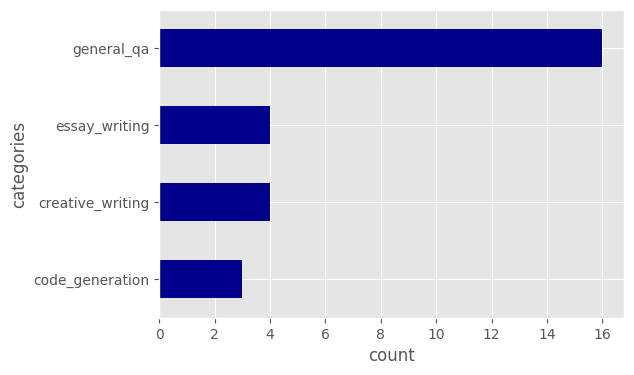

In [ ]:
f, ax = plt.subplots(figsize=(6,4))
custom_questions_df['category'].value_counts()[::-1].plot(
    color='darkblue', kind='barh', ax=ax
    )
ax.set_xlabel('count',  fontsize=12)
ax.set_ylabel('categories', fontsize=12)
plt.show()

## 3.1. General QA

In [ ]:
eval_col = 'general_qa'
temp_prompts_df = custom_questions_df[custom_questions_df['category'] == eval_col]

for temp_prompt in temp_prompts_df['instruction']:
    print('\n')
    temp_answer = get_response_with_output(hf_llm_chain, temp_prompt, 80,
                                           is_show_reply)

## 3.2. Essay writing

In [ ]:
eval_col = 'essay_writing'
temp_prompts_df = custom_questions_df[custom_questions_df['category'] == eval_col]

for temp_prompt in temp_prompts_df['instruction']:
    print('\n')
    temp_answer = get_response_with_output(hf_llm_chain, temp_prompt, 80,
                                           is_show_reply)

## 3.3. Creative writing

In [ ]:
eval_col = 'creative_writing'
temp_prompts_df = custom_questions_df[custom_questions_df['category'] == eval_col]

for temp_prompt in temp_prompts_df['instruction']:
    print('\n')
    temp_answer = get_response_with_output(hf_llm_chain, temp_prompt, 80,
                                           is_show_reply)

## 3.4. Code generation

In [ ]:
eval_col = 'code_generation'
temp_prompts_df = custom_questions_df[custom_questions_df['category'] == eval_col]

for temp_prompt in temp_prompts_df['instruction']:
    print('\n')
    temp_answer = get_response_with_output(hf_llm_chain, temp_prompt, 80,
                                           is_show_reply)

**Test here if the Regex works**:

In [ ]:
# import re
# year_regex = r'(?<=, )(\d{4})'
# string = "The Downward Spiral, Nine Inch Nails (1994)"
# matched_year = re.search(year_regex, string).group()
# print(matched_year) # Output: 1994

# **4. Save Results**

In [ ]:
# TBD